# WIP: An Interactive Plotting Backend for `pyrolite`

In [11]:
from pyrolite.data.Aitchison import load_kongite
from pyrolite.util.log import Handle
from pyrolite.util.plot.backend import Backend

logger = Handle("pyrolite", level="DEBUG")

## Interface Switching

In [12]:
with Backend("plotly"):
    with Backend("matplotlib"):
        ...
    ...

2024-11-15 14:40:29,609 pyrolite.util.plot.backend - DEBUG: Setting plotting backend to plotly
2024-11-15 14:40:29,611 pyrolite.util.plot.backend - DEBUG: Setting plotting backend to matplotlib
2024-11-15 14:40:29,612 pyrolite.util.plot.backend - DEBUG: Reverting plotting backend to plotly
2024-11-15 14:40:29,613 pyrolite.util.plot.backend - DEBUG: Reverting plotting backend to matplotlib


## Some Example Data

In [13]:
from pyrolite.util.synthetic import example_spider_data

logger.setLevel("INFO")

ree_df = example_spider_data(
    noise_level=0.05,
    size=100,
    start="DMM_WH2005",
    norm_to="Chondrite_PON",
    offsets={"Eu": 0.2},
).pyrochem.REE

df = load_kongite()
df.head()


,A,B,C,D,E
Specimen,,,,,
K1,33.5,6.1,41.3,7.1,12.0
K2,47.6,14.9,16.1,14.8,6.6
K3,52.7,23.9,6.0,8.7,8.7
K4,44.5,24.2,10.7,11.9,8.7
K5,42.3,47.6,0.6,4.1,5.4


## Plot API Comparison - Example for Scatter, Spider Plots

<Axes: xlabel='B', ylabel='C'>

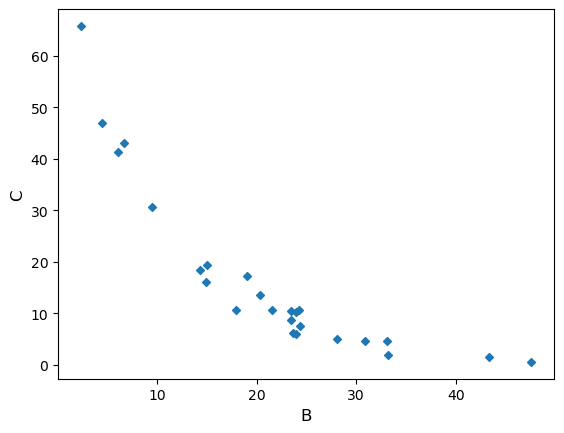

In [14]:
df.iloc[:, 1:3].pyroplot.scatter()

In [15]:
with Backend("plotly"):
    fig = df.iloc[:, 1:3].pyroplot.scatter()

fig

In [24]:
df.iloc[:, 1:3].pyroplot.scatter(backend="plotly")

<TernaryAxes: tlabel='A', llabel='B', rlabel='C'>

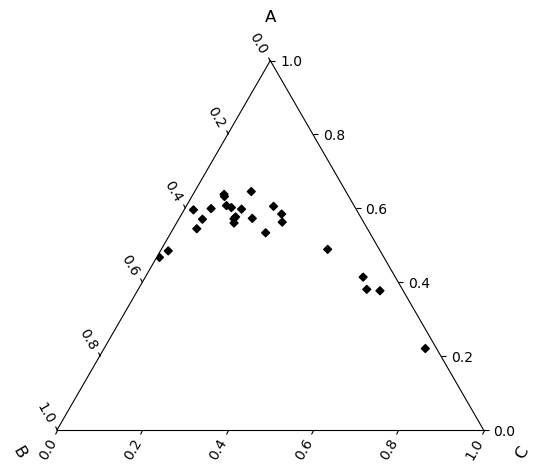

In [16]:
df.iloc[:, :3].pyroplot.scatter(color="k")

In [17]:
with Backend("plotly"):
    fig = df.iloc[:, :3].pyroplot.scatter(color="k")

fig
# fig.write_html("ternary.html")

<Axes: >

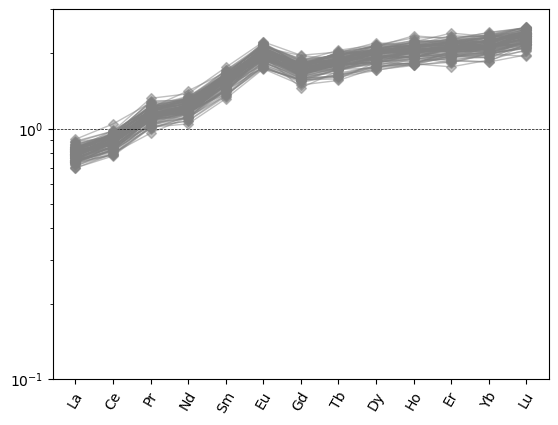

In [18]:
ree_df.pyroplot.spider(unity_line=True, color="0.5", alpha=0.5)

In [19]:
lambda_labels = (
    ree_df.pyrochem.lambda_lnREE(anomalies=["Eu"])
    .apply(lambda x: x.apply(lambda y: "{}: {:2.2f}".format(x.name, y)))
    .agg("<br>".join, axis=1)
)

with Backend("plotly"):
    fig = ree_df.pyroplot.spider(
        unity_line=True, color="0.5", alpha=0.5, width=600, text=lambda_labels
    )
fig